## Import package

In [21]:
from __future__ import division
    
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import ADASYN, SMOTE

## Load dataset: Train

In [22]:
train = pd.read_csv("../../../../../data/train/train.csv")
test = pd.read_csv("../../../../../data/test/test.csv")

In [23]:
print(train.shape)
print(test.shape)

(9557, 143)
(23856, 142)


In [24]:
train.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [25]:
test.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [26]:
f = open("../../../resources/continuousFeatures", "r")
continuous_columns = f.read().split(",")
f.close()

f = open("../../../resources/categoricalFeatures", "r")
categorical_columns = f.read().split(",")
f.close()

f = open("../../../resources/yesNoFeaturesNames", "r")
yes_no_columns = f.read().split(",")
f.close()

print("Number of numerical columns: {0}".format(len(continuous_columns)))
print("Number of categorical columns: {0}".format(len(categorical_columns)))
print("Number of yes/no columns: {0}".format(len(yes_no_columns)))

Number of numerical columns: 38
Number of categorical columns: 102
Number of yes/no columns: 3


In [27]:
category, category_ount = np.unique(train["Target"], return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_ount)))

(Category, Count): [(1, 755), (2, 1597), (3, 1209), (4, 5996)]


## Fil Yes/No values

In [28]:
# yes=1 and no=0
def fill_yes_no(value):
    if value == "yes":
        return 1.0
    elif value == "no":
        return 0.0
    else:
        return float(value)

In [29]:
for column in yes_no_columns:
    train["new_{0}".format(column)] = train.apply(lambda row: fill_yes_no(row[column]), axis=1)
    test["new_{0}".format(column)] = test.apply(lambda row: fill_yes_no(row[column]), axis=1)

train = train.drop(yes_no_columns, axis=1)
test = test.drop(yes_no_columns, axis=1)

columns={"new_{0}".format(column): column for column in yes_no_columns}
train = train.rename(index=str, columns=columns)
test = test.rename(index=str, columns=columns)

## Fill Nan values

In [30]:
null_columns = train.isnull().any()

In [31]:
null_columns = train.columns[train.isnull().any()].tolist() ## continuous variables
null_columns

['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']

In [32]:
train[["Target","v2a1", 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']].head()

,Target,v2a1,v18q1,rez_esc,meaneduc,SQBmeaned
0,4,190000.0,NaN,NaN,10.0,100.0
1,4,135000.0,1.0,NaN,12.0,144.0
2,4,NaN,NaN,NaN,11.0,121.0
3,4,180000.0,1.0,1.0,11.0,121.0
4,4,180000.0,1.0,NaN,11.0,121.0


In [33]:
label_mean = train[null_columns].mean()
# label_mean.to_dict()

In [34]:
label_mean

v2a1         165231.606971
v18q1             1.404063
rez_esc           0.459791
meaneduc          9.231523
SQBmeaned       102.588867
dtype: float64

In [35]:
for column in null_columns:
    train["new_{0}".format(column)] = train.apply(
    lambda row: label_mean[column] if np.isnan(row[column]) else row[column],
    axis=1)
    
    test["new_{0}".format(column)] = test.apply(
    lambda row: label_mean[column] if np.isnan(row[column]) else row[column],
    axis=1)    

train = train.drop(null_columns, axis=1)
test = test.drop(null_columns, axis=1)
train = train.rename(index=str, columns={"new_{0}".format(column): column for column in null_columns})
test = test.rename(index=str, columns={"new_{0}".format(column): column for column in null_columns})

## Standard scaled

In [36]:
from sklearn.preprocessing import StandardScaler
estimator = StandardScaler(copy=True, with_mean=True, with_std=True)
model = estimator.fit(train[continuous_columns])
X_scaled = model.transform(train[continuous_columns])
x_test_scaled = model.transform(test[continuous_columns])

## Train - Validation split

In [37]:
X_train, X_validation, y_train, y_validation = train_test_split(X_scaled, train["Target"], test_size=0.2, stratify=train["Target"])

In [38]:
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

((7645, 38), (7645,))
((1912, 38), (1912,))


In [39]:
category, category_count = np.unique(y_train, return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_count)))
      
category, category_count = np.unique(y_validation, return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_count)))     

(Category, Count): [(1, 604), (2, 1278), (3, 967), (4, 4796)]
(Category, Count): [(1, 151), (2, 319), (3, 242), (4, 1200)]


## Balanced datasets - SMOTE

In [40]:
smo = SMOTE(kind="svm")
X_resampled, y_resampled = smo.fit_sample(X_train, y_train)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 17:46:40.138358. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## Utilities functions

In [41]:
def all_score(y_true, y_prediction):
    accuracy = accuracy_score(y_true, y_prediction)
    precision = precision_score(y_true, y_prediction, average="macro")
    recall = recall_score(y_true, y_prediction, average="macro")
    f1 = f1_score(y_true, y_prediction, average="macro")
    return accuracy, precision, recall, f1

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 17:46:53.603987. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [42]:
def print_score(accuracy, precision, recall, f1):
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 17:46:53.615266. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## Classification: Random Forest Classifier

In [44]:
estimator = RandomForestClassifier()
model = estimator.fit(X_resampled, y_resampled)
prediction_validation = model.predict(X_validation)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 17:50:39.084592. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


('Accuracy:', 0.877092050209205)
('Precision:', 0.8292274388228769)
('Recall:', 0.8086812281663611)
('F1:', 0.8182511101476588)
[[ 115   18    2   16]
 [  12  251   15   41]
 [   5   18  180   39]
 [  15   35   19 1131]]


/home/mahjoubi/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/mahjoubi/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


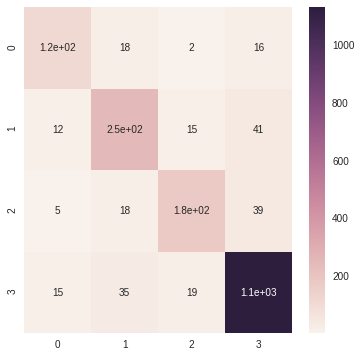

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 17:51:33.021553. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [49]:
accuracy, precision, recall, f1 = all_score(y_validation, prediction_validation)
print_score(accuracy, precision, recall, f1)

confusion_mc = confusion_matrix(y_validation, prediction_validation)
print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

In [51]:
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(prediction_validation, y_validation, target_names=target_names))

             precision    recall  f1-score   support

    class 1       0.76      0.78      0.77       147
    class 2       0.79      0.78      0.78       322
    class 3       0.74      0.83      0.79       216
    class 4       0.94      0.92      0.93      1227

avg / total       0.88      0.88      0.88      1912



/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 17:51:40.283810. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## Classifier: GradientBoostingClassifier

In [55]:
estimator = GradientBoostingClassifier()
model = estimator.fit(X_resampled, y_resampled)
prediction_validation = model.predict(X_validation)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 17:53:27.903349. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


('Accuracy:', 0.6861924686192469)
('Precision:', 0.5509963562061624)
('Recall:', 0.55441713856894)
('F1:', 0.5505874224128293)
[[ 62  40  22  27]
 [ 25 162  50  82]
 [ 11  37 119  75]
 [ 34  81 116 969]]


/home/mahjoubi/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/mahjoubi/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


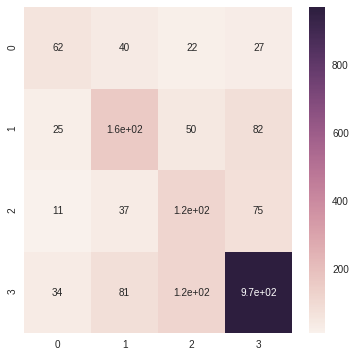

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 17:54:11.743585. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [56]:
accuracy, precision, recall, f1 = all_score(y_validation, prediction_validation)
print_score(accuracy, precision, recall, f1)

confusion_mc = confusion_matrix(y_validation, prediction_validation)
print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

In [57]:
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(prediction_validation, y_validation, target_names=target_names))

             precision    recall  f1-score   support

    class 1       0.41      0.47      0.44       132
    class 2       0.51      0.51      0.51       320
    class 3       0.49      0.39      0.43       307
    class 4       0.81      0.84      0.82      1153

avg / total       0.68      0.69      0.68      1912



/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 17:55:35.039761. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## Classifier: ExtraTreesClassifier

In [81]:
estimator = ExtraTreesClassifier(n_estimators=200)
model = estimator.fit(X_resampled, y_resampled)
prediction_validation = model.predict(X_validation)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 18:07:33.614813. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


('Accuracy:', 0.9058577405857741)
('Precision:', 0.8815808268512956)
('Recall:', 0.8512114492566262)
('F1:', 0.865572248028302)
[[ 126   16    1    8]
 [   6  263   11   39]
 [   1   15  190   36]
 [   8   22   17 1153]]


/home/mahjoubi/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/mahjoubi/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


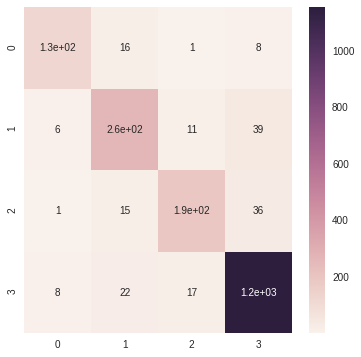

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 18:07:36.689129. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [82]:
accuracy, precision, recall, f1 = all_score(y_validation, prediction_validation)
print_score(accuracy, precision, recall, f1)

confusion_mc = confusion_matrix(y_validation, prediction_validation)
print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

## Classifier: BaggingClassifier

In [65]:
estimator = BaggingClassifier()
model = estimator.fit(X_resampled, y_resampled)
prediction_validation = model.predict(X_validation)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 18:00:53.093077. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


('Accuracy:', 0.8645397489539749)
('Precision:', 0.8206632612876825)
('Recall:', 0.7948602686437964)
('F1:', 0.8069966208835415)
[[ 113   21    0   17]
 [   9  245   17   48]
 [   3   18  177   44]
 [  11   38   33 1118]]


/home/mahjoubi/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/mahjoubi/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


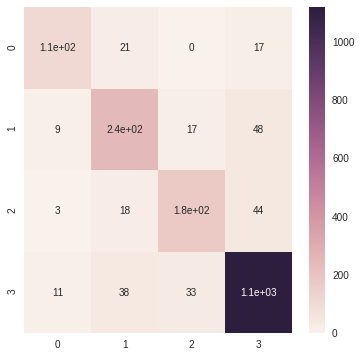

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 18:01:09.194473. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [66]:
accuracy, precision, recall, f1 = all_score(y_validation, prediction_validation)
print_score(accuracy, precision, recall, f1)

confusion_mc = confusion_matrix(y_validation, prediction_validation)
print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

## Classifier: AdaBoostClassifier

In [67]:
estimator = AdaBoostClassifier()
model = estimator.fit(X_resampled, y_resampled)
prediction_validation = model.predict(X_validation)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 18:02:45.348144. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


('Accuracy:', 0.5852510460251046)
('Precision:', 0.4479596129331476)
('Recall:', 0.4710308780260409)
('F1:', 0.44899222677388007)
[[ 57  51  20  23]
 [ 47 111  96  65]
 [ 18  47 111  66]
 [ 59  80 221 840]]


/home/mahjoubi/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/mahjoubi/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


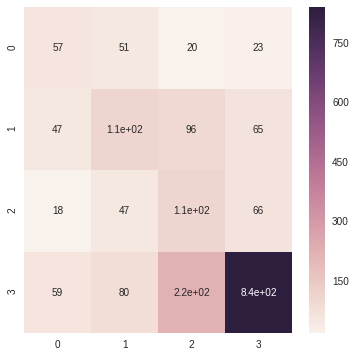

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-05 18:02:56.035410. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [68]:
accuracy, precision, recall, f1 = all_score(y_validation, prediction_validation)
print_score(accuracy, precision, recall, f1)

confusion_mc = confusion_matrix(y_validation, prediction_validation)
print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

## Hyper-parameters tuning

In [ ]:
reg_params = [1e-7, 0.000001, 0.00001, 0.0001, 0.001,0.01,0.1,1,10,100,1000]
accuracy_scores = {"train": [], "validation": []}
precision_scores = {"train": [], "validation": []}
recall_scores = {"train": [], "validation": []}
f1_scores = {"train": [], "validation": []}
print("Number of neighbor: "),
for reg_param in reg_params:
    print(", {0}".format(reg_param)),
    prediction_smo_train, prediction_smo_validation = logistic_regression_prediction(reg_param, X_smo_train, y_smo_train, X_smo_validation)
    accuracy, precision, recall, f1 = all_score(y_smo_train, prediction_smo_train)
    accuracy_scores["train"].append(accuracy)
    precision_scores["train"].append(precision)
    recall_scores["train"].append(recall)
    f1_scores["train"].append(f1)  
    
    accuracy, precision, recall, f1 = all_score(y_smo_validation, prediction_smo_validation)
    accuracy_scores["validation"].append(accuracy)
    precision_scores["validation"].append(precision)
    recall_scores["validation"].append(recall)    
    f1_scores["validation"].append(f1)

In [ ]:
regs = [1/reg for reg in reg_params]
regs

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0][0].semilogx(regs, accuracy_scores["train"], c="r", label="train")
ax[0][0].semilogx(regs, accuracy_scores["validation"], c="g", label="validation")
ax[0][0].set_title("Accuracy")
ax[0][0].legend()

ax[0][1].semilogx(regs, f1_scores["train"], c="r", label="train")
ax[0][1].semilogx(regs, f1_scores["validation"], c="g", label="validation")
ax[0][1].set_title("F1")
ax[0][1].legend()

ax[1][0].semilogx(regs, precision_scores["train"], c="r", label="train")
ax[1][0].semilogx(regs, precision_scores["validation"], c="g", label="validation")
ax[1][0].set_title("precision")
ax[1][0].legend()

ax[1][1].semilogx(regs, recall_scores["train"], c="r", label="train")
ax[1][1].semilogx(regs, recall_scores["validation"], c="g", label="validation")
ax[1][1].set_title("recall")
ax[1][1].legend()

In [ ]:
nearest_neighbors = LogisticRegression(C=1000)
model = nearest_neighbors.fit(X_smo_train, y_smo_train)
prediction_smo_validation = model.predict(X_smo_validation)


# print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

In [ ]:
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(prediction_smo_validation, y_smo_validation, target_names=target_names))

In [ ]:
prediction_kaggle = model.predict(x_test_scaled)

In [ ]:
unique_elements, counts_elements = np.unique(prediction_kaggle, return_counts=True)
print(unique_elements)
print(counts_elements)

In [ ]:
id_kaggle = test["Id"]

In [ ]:
d = {"Id": id_kaggle, "Target": prediction_kaggle}
data = pd.DataFrame(d)

In [ ]:
data.head(5)

In [ ]:
data.to_csv("/home/ubuntu/Documents/costa_rican_household_poverty/submission/sklearn/smote/logisticRegression.csv", index=False)